## File Pre-process

In [7]:
import os 
import shutil
# get the current working directory 
path = os.getcwd()
print(path)
# get the relevant file names under the current working directory
file_name = os.listdir(path)
print(file_name)

d:\PYTHON\Vscode\Kaggle\NLPdisaster
['extracted', 'implmentKeras.ipynb', 'nlp-getting-started.zip', 'submission.csv', 'submission_example.csv', 'test_trainer']


In [3]:
# Using . as current directory, .. as parent directory
print(os.listdir("."))

['extracted', 'implmentKeras.ipynb', 'nlp-getting-started.zip', 'submission.csv', 'submission_example.csv', 'test_trainer']


In [8]:
# Define the path to the extracted folder
extracted_folder_path = os.path.join(os.getcwd(), "extracted")

try:
    # Attempt to delete the folder and its contents
    shutil.rmtree(extracted_folder_path)
    print("Existing folder deleted.")
except FileNotFoundError:
    # The folder does not exist
    print("Folder does not exist, ready to extract.")
except Exception as e:
    # Handle other exceptions, such as permission errors
    print(f"Error occurred: {e}")

# Proceed with the extraction
# Assuming the zip file is the second file in the directory listing, adjust as needed
zip_file_path = os.path.join(os.getcwd(), os.listdir(".")[1])

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_folder_path)
    print("Extraction completed.")

Existing folder deleted.
Extraction completed.


## Data Pre-process

In [9]:
## 复现 教程
import numpy as np
import pandas as pd

In [10]:
train_pd = pd.read_csv(extracted + "/train.csv")
print(train_pd.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [11]:
# print the columns that target is 0 
print(train_pd[train_pd["target"] == 0].head())

    id keyword location                          text  target
15  23     NaN      NaN                What's up man?       0
16  24     NaN      NaN                 I love fruits       0
17  25     NaN      NaN              Summer is lovely       0
18  26     NaN      NaN             My car is so fast       0
19  28     NaN      NaN  What a goooooooaaaaaal!!!!!!       0


<Axes: ylabel='Frequency'>

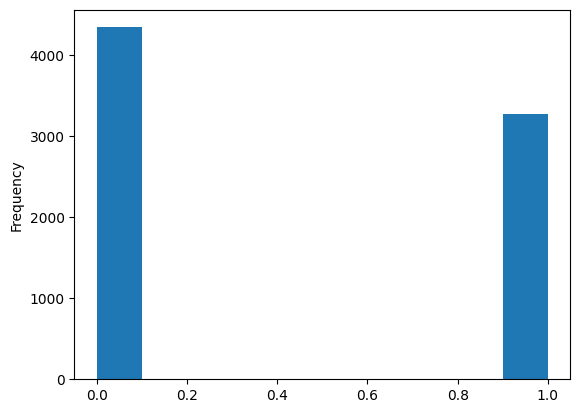

In [12]:
# plot the distribution of the target
train_pd["target"].plot.hist()

In [13]:
test_pd = pd.read_csv(extracted + "/test.csv")
# print the shape 
print(f"train shape: {train_pd.shape}, test shape: {test_pd.shape}")


train shape: (7613, 5), test shape: (3263, 4)


In [14]:
# add extra column to train and test to calculate the length 
train_pd["len"] = train_pd['text'].apply(lambda x: len(x))
test_pd["len"] = test_pd['text'].apply(lambda x: len(x))

In [15]:
train_pd["len"][:4]

0     69
1     38
2    133
3     65
Name: len, dtype: int64

<Axes: >

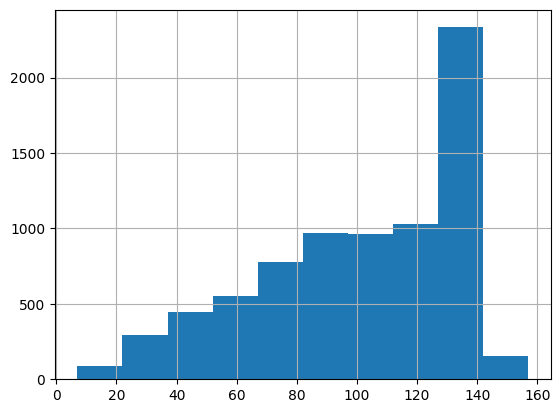

In [16]:
train_pd['len'].hist()

In [17]:
# the maximum length of the text
print(f"max length of the text in the train: {train_pd['len'].max()}")

max length of the text in the train: 157


In [18]:
# process the data 
X = train_pd['text']
y = train_pd['target']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (6090,), X_test shape: (1523,)


## Distilled Bert

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
# add drop out to the model
drop_out = 0.2

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased").to("cuda")

d:\PYTHON\ENV\labsession\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# tokenizer 
X_train_tokenized = tokenizer(X_train.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)

In [23]:
X_test_tokenized = tokenizer(X_test.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)

In [24]:
# model
with torch.no_grad():
    X_train_encoded = model(**X_train_tokenized.to("cuda"))

# this three dim stands for batch size, sequence length, hidden size

In [25]:
with torch.no_grad():
    X_test_encoded = model(**X_test_tokenized.to("cuda"))

# print(X_test_encoded.last_hidden_state.shape)

In [26]:
# process y 
# Instead of .to("cuda"), keep them on the CPU
y_train = torch.tensor(y_train.tolist())  # Already on CPU by default
y_test = torch.tensor(y_test.tolist())    # Already on CPU by default

print(y_train.shape, y_test.shape)

torch.Size([6090]) torch.Size([1523])


In [27]:
# check our model 
model.config

DistilBertConfig {
  "_name_or_path": "distilbert/distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

In [29]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: v.cpu() for k, v in encodings.items()}  # Ensure encodings are on CPU
        self.labels = labels.cpu()  # Ensure labels are on CPU

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # Clone to ensure no grad
        item['labels'] = self.labels[idx].clone().detach()  # Clone to ensure no grad
        return item

    def __len__(self):
        return len(self.labels)


# Create instances of CustomDataset
train_dataset = CustomDataset(X_train_tokenized, y_train)
test_dataset = CustomDataset(X_test_tokenized, y_test)


In [36]:


# Specify the path to the checkpoint folder
checkpoint_folder = "./test_trainer"

try:
    # Attempt to delete the checkpoint folder and its contents
    shutil.rmtree(checkpoint_folder)
    print(f"Deleted existing checkpoint folder: {checkpoint_folder}")
except FileNotFoundError:
    # The checkpoint folder does not exist
    print("No existing checkpoint folder to delete.")
except Exception as e:
    # An unexpected error occurred
    print(f"Error occurred while trying to delete checkpoint folder: {e}")

# Proceed with the rest of your script here, such as setting up TrainingArguments and initializing the Trainer


Deleted existing checkpoint folder: ./test_trainer


In [37]:
## batch 
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(output_dir = "test_trainer",
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  num_train_epochs=5,
                                  warmup_steps=500,
                                  weight_decay=0.01,
                                  logging_dir="./logs",
                                  logging_steps=100,)


trainer= Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset)

trainer.train()

d:\PYTHON\ENV\labsession\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  3%|▎         | 102/3810 [00:07<02:55, 21.13it/s]

{'loss': 0.0542, 'grad_norm': 0.2939712703227997, 'learning_rate': 1e-05, 'epoch': 0.13}


  5%|▌         | 204/3810 [00:11<02:45, 21.77it/s]

{'loss': 0.1165, 'grad_norm': 0.2624434232711792, 'learning_rate': 2e-05, 'epoch': 0.26}


  8%|▊         | 303/3810 [00:16<02:43, 21.40it/s]

{'loss': 0.1001, 'grad_norm': 0.05035383254289627, 'learning_rate': 3e-05, 'epoch': 0.39}


 11%|█         | 405/3810 [00:21<02:38, 21.52it/s]

{'loss': 0.0834, 'grad_norm': 0.0066613624803721905, 'learning_rate': 4e-05, 'epoch': 0.52}


 13%|█▎        | 500/3810 [00:25<02:31, 21.84it/s]

{'loss': 0.1069, 'grad_norm': 0.01729053445160389, 'learning_rate': 5e-05, 'epoch': 0.66}


 16%|█▌        | 603/3810 [00:30<02:31, 21.21it/s]

{'loss': 0.1128, 'grad_norm': 0.01970563270151615, 'learning_rate': 4.848942598187312e-05, 'epoch': 0.79}


 18%|█▊        | 702/3810 [00:35<02:25, 21.40it/s]

{'loss': 0.1932, 'grad_norm': 8.049954414367676, 'learning_rate': 4.6978851963746225e-05, 'epoch': 0.92}


 21%|██        | 804/3810 [00:40<02:19, 21.62it/s]

{'loss': 0.1259, 'grad_norm': 161.18673706054688, 'learning_rate': 4.546827794561934e-05, 'epoch': 1.05}


 24%|██▎       | 903/3810 [00:44<02:16, 21.23it/s]

{'loss': 0.0656, 'grad_norm': 0.017494676634669304, 'learning_rate': 4.395770392749245e-05, 'epoch': 1.18}


 26%|██▌       | 1000/3810 [00:49<02:08, 21.81it/s]

{'loss': 0.1454, 'grad_norm': 0.1460566371679306, 'learning_rate': 4.244712990936556e-05, 'epoch': 1.31}


 29%|██▉       | 1104/3810 [00:54<02:04, 21.76it/s]

{'loss': 0.1319, 'grad_norm': 0.012167723849415779, 'learning_rate': 4.093655589123867e-05, 'epoch': 1.44}


 32%|███▏      | 1203/3810 [00:59<01:59, 21.87it/s]

{'loss': 0.1348, 'grad_norm': 5.173732757568359, 'learning_rate': 3.9425981873111784e-05, 'epoch': 1.57}


 34%|███▍      | 1305/3810 [01:03<01:52, 22.24it/s]

{'loss': 0.1329, 'grad_norm': 0.03252275288105011, 'learning_rate': 3.79154078549849e-05, 'epoch': 1.71}


 37%|███▋      | 1404/3810 [01:08<01:49, 22.00it/s]

{'loss': 0.0888, 'grad_norm': 0.06693843007087708, 'learning_rate': 3.640483383685801e-05, 'epoch': 1.84}


 39%|███▉      | 1500/3810 [01:12<01:44, 22.10it/s]

{'loss': 0.1581, 'grad_norm': 0.2668377459049225, 'learning_rate': 3.489425981873112e-05, 'epoch': 1.97}


 42%|████▏     | 1605/3810 [01:17<01:40, 21.88it/s]

{'loss': 0.1029, 'grad_norm': 0.07166309654712677, 'learning_rate': 3.338368580060423e-05, 'epoch': 2.1}


 45%|████▍     | 1704/3810 [01:22<01:35, 21.95it/s]

{'loss': 0.0501, 'grad_norm': 0.050900209695100784, 'learning_rate': 3.187311178247734e-05, 'epoch': 2.23}


 47%|████▋     | 1803/3810 [01:26<01:33, 21.48it/s]

{'loss': 0.0977, 'grad_norm': 0.9935785531997681, 'learning_rate': 3.0362537764350457e-05, 'epoch': 2.36}


 50%|████▉     | 1902/3810 [01:31<01:27, 21.74it/s]

{'loss': 0.0711, 'grad_norm': 0.007462955545634031, 'learning_rate': 2.8851963746223565e-05, 'epoch': 2.49}


 52%|█████▏    | 2000/3810 [01:35<01:22, 21.90it/s]

{'loss': 0.0812, 'grad_norm': 7.92999267578125, 'learning_rate': 2.734138972809668e-05, 'epoch': 2.62}


 55%|█████▌    | 2103/3810 [01:40<01:17, 22.08it/s]

{'loss': 0.0866, 'grad_norm': 10.534989356994629, 'learning_rate': 2.583081570996979e-05, 'epoch': 2.76}


 58%|█████▊    | 2202/3810 [01:45<01:12, 22.24it/s]

{'loss': 0.0703, 'grad_norm': 0.03986269608139992, 'learning_rate': 2.43202416918429e-05, 'epoch': 2.89}


 60%|██████    | 2304/3810 [01:50<01:07, 22.27it/s]

{'loss': 0.0701, 'grad_norm': 0.010195632465183735, 'learning_rate': 2.2809667673716012e-05, 'epoch': 3.02}


 63%|██████▎   | 2403/3810 [01:54<01:03, 22.27it/s]

{'loss': 0.0315, 'grad_norm': 0.01080079935491085, 'learning_rate': 2.1299093655589124e-05, 'epoch': 3.15}


 66%|██████▌   | 2500/3810 [01:58<00:58, 22.26it/s]

{'loss': 0.0849, 'grad_norm': 0.008697696961462498, 'learning_rate': 1.9788519637462235e-05, 'epoch': 3.28}


 68%|██████▊   | 2604/3810 [02:04<00:55, 21.80it/s]

{'loss': 0.0764, 'grad_norm': 33.17705535888672, 'learning_rate': 1.827794561933535e-05, 'epoch': 3.41}


 71%|███████   | 2703/3810 [02:08<00:50, 21.78it/s]

{'loss': 0.0526, 'grad_norm': 0.00791336689144373, 'learning_rate': 1.676737160120846e-05, 'epoch': 3.54}


 74%|███████▎  | 2802/3810 [02:13<00:46, 21.83it/s]

{'loss': 0.0524, 'grad_norm': 0.19626398384571075, 'learning_rate': 1.5256797583081573e-05, 'epoch': 3.67}


 76%|███████▌  | 2904/3810 [02:17<00:41, 21.76it/s]

{'loss': 0.0415, 'grad_norm': 0.4594835638999939, 'learning_rate': 1.3746223564954682e-05, 'epoch': 3.81}


 79%|███████▊  | 3000/3810 [02:22<00:37, 21.83it/s]

{'loss': 0.0423, 'grad_norm': 1.807619333267212, 'learning_rate': 1.2235649546827795e-05, 'epoch': 3.94}


 81%|████████▏ | 3102/3810 [02:27<00:33, 21.37it/s]

{'loss': 0.0553, 'grad_norm': 0.004785178694874048, 'learning_rate': 1.0725075528700906e-05, 'epoch': 4.07}


 84%|████████▍ | 3204/3810 [02:32<00:28, 21.52it/s]

{'loss': 0.0384, 'grad_norm': 0.0042624385096132755, 'learning_rate': 9.214501510574018e-06, 'epoch': 4.2}


 87%|████████▋ | 3303/3810 [02:36<00:23, 21.60it/s]

{'loss': 0.033, 'grad_norm': 1.7657631635665894, 'learning_rate': 7.70392749244713e-06, 'epoch': 4.33}


 89%|████████▉ | 3405/3810 [02:41<00:18, 22.01it/s]

{'loss': 0.0514, 'grad_norm': 0.0046674711629748344, 'learning_rate': 6.193353474320241e-06, 'epoch': 4.46}


 92%|█████████▏| 3500/3810 [02:45<00:14, 21.96it/s]

{'loss': 0.0303, 'grad_norm': 0.003218071535229683, 'learning_rate': 4.682779456193353e-06, 'epoch': 4.59}


 95%|█████████▍| 3603/3810 [02:50<00:09, 21.83it/s]

{'loss': 0.0267, 'grad_norm': 0.003060894086956978, 'learning_rate': 3.1722054380664653e-06, 'epoch': 4.72}


 97%|█████████▋| 3705/3810 [02:55<00:04, 21.88it/s]

{'loss': 0.0398, 'grad_norm': 119.60929107666016, 'learning_rate': 1.661631419939577e-06, 'epoch': 4.86}


100%|█████████▉| 3804/3810 [03:00<00:00, 22.03it/s]

{'loss': 0.0423, 'grad_norm': 1.1280299425125122, 'learning_rate': 1.5105740181268883e-07, 'epoch': 4.99}


100%|██████████| 3810/3810 [03:00<00:00, 21.13it/s]

{'train_runtime': 180.3328, 'train_samples_per_second': 168.854, 'train_steps_per_second': 21.128, 'train_loss': 0.08087695457647479, 'epoch': 5.0}


TrainOutput(global_step=3810, training_loss=0.08087695457647479, metrics={'train_runtime': 180.3328, 'train_samples_per_second': 168.854, 'train_steps_per_second': 21.128, 'train_loss': 0.08087695457647479, 'epoch': 5.0})

```
training_args = TrainingArguments(output_dir = "test_trainer",
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  num_train_epochs=5,
                                  logging_dir="./logs",
                                  logging_steps=10,)
```

这个loggingfrequency会返回很多epoch

In [62]:
# from transformers import Trainer, TrainingArguments
# training_args = TrainingArguments("test_trainer")


# trainer= Trainer(model=model,
#                   args=training_args,
#                   train_dataset=train_dataset,
#                   eval_dataset=test_dataset)

# trainer.train()

d:\PYTHON\ENV\labsession\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
 22%|██▏       | 500/2286 [00:22<01:19, 22.58it/s]

{'loss': 0.4635, 'grad_norm': 4.250698089599609, 'learning_rate': 3.906386701662293e-05, 'epoch': 0.66}


 44%|████▎     | 1000/2286 [00:45<00:57, 22.36it/s]

{'loss': 0.3799, 'grad_norm': 0.9546465277671814, 'learning_rate': 2.8127734033245845e-05, 'epoch': 1.31}


 66%|██████▌   | 1500/2286 [01:08<00:34, 23.11it/s]

{'loss': 0.3355, 'grad_norm': 10.752007484436035, 'learning_rate': 1.7191601049868766e-05, 'epoch': 1.97}


 87%|████████▋ | 2000/2286 [01:31<00:12, 22.56it/s]

{'loss': 0.2128, 'grad_norm': 12.658132553100586, 'learning_rate': 6.255468066491689e-06, 'epoch': 2.62}


100%|██████████| 2286/2286 [01:44<00:00, 21.89it/s]

{'train_runtime': 104.4352, 'train_samples_per_second': 174.941, 'train_steps_per_second': 21.889, 'train_loss': 0.33185428208879286, 'epoch': 3.0}


TrainOutput(global_step=2286, training_loss=0.33185428208879286, metrics={'train_runtime': 104.4352, 'train_samples_per_second': 174.941, 'train_steps_per_second': 21.889, 'train_loss': 0.33185428208879286, 'epoch': 3.0})

In [38]:
# evaluate the model



# test the model
# load the test data
X_val = test_pd['text']

X_val_tokenized = tokenizer(X_val.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)


# create the dataset


# make the prediction
with torch.no_grad():
    X_val_encoded = model(**X_val_tokenized.to("cuda"))

# write the prediction to a csv file
# get the prediction
y_val = torch.argmax(X_val_encoded.logits, dim=1).cpu().numpy()




In [43]:
# create the submission file
from sklearn.metrics import f1_score
submission = pd.DataFrame()
submission['id'] = test_pd['id']
submission['target'] = y_val
submission.to_csv("submission.csv", index=False)

# 
with open("submission_example.csv", "r") as f:
    # check the accuracy
    submission_example = pd.read_csv(f)

    # check the accuracy
accuracy = (submission_example['target'] == submission['target']).mean()
print(f"Accuracy: {accuracy}")
# check the f1 score
f1 = f1_score(submission_example['target'], submission['target'])
print(f"F1 Score: {f1}")




Accuracy: 0.8994790070487282
F1 Score: 0.8681672025723473


## Bert uncased normal model 

In [44]:
## let's try another bert 
tokenizer_new = AutoTokenizer.from_pretrained("bert-base-uncased")
model_new = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased").to("cuda")


d:\PYTHON\ENV\labsession\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\PYTHON\cacheTransformers\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [45]:
# tokenize_x 
X_train_tokenized_new = tokenizer_new(X_train.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)
X_test_tokenized_new = tokenizer_new(X_test.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)
y_train = torch.tensor(y_train.tolist())  # Already on CPU by default
y_test = torch.tensor(y_test.tolist())    # Already on CPU by default


In [50]:
# create the dataset
train_dataset_new = CustomDataset(X_train_tokenized_new, y_train)
test_dataset_new = CustomDataset(X_test_tokenized_new, y_test)

# Specify the path to the checkpoint folder
checkpoint_folder = "./test_trainer_newbert"
# ## batch 
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(output_dir = "test_trainer_newbert",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=10,
                                  warmup_steps=500,
                                  weight_decay=0.01,
                                  logging_dir="./logs_new",
                                  logging_steps=5000,)


trainer= Trainer(model=model_new,
                  args=training_args,
                  train_dataset=train_dataset_new,
                  eval_dataset=test_dataset_new)

trainer.train()

d:\PYTHON\ENV\labsession\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
100%|██████████| 3810/3810 [07:26<00:00,  8.53it/s]

{'train_runtime': 446.6418, 'train_samples_per_second': 136.351, 'train_steps_per_second': 8.53, 'train_loss': 0.06501716753942134, 'epoch': 10.0}


TrainOutput(global_step=3810, training_loss=0.06501716753942134, metrics={'train_runtime': 446.6418, 'train_samples_per_second': 136.351, 'train_steps_per_second': 8.53, 'train_loss': 0.06501716753942134, 'epoch': 10.0})

In [51]:
# test the model
# load the test data
X_val_new = test_pd['text']# evaluate the model



# test the model
# load the test data
X_val_new = test_pd['text']


X_val_tokenized_new = tokenizer_new(X_val_new.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)


# create the dataset


# make the prediction
with torch.no_grad():
    X_val_encoded_new = model_new(**X_val_tokenized_new.to("cuda"))

# write the prediction to a csv file
# get the prediction
y_val_new = torch.argmax(X_val_encoded_new.logits, dim=1).cpu().numpy()





In [56]:
# create the submission file
from sklearn.metrics import f1_score
submission_bert = pd.DataFrame()
submission_bert['id'] = test_pd['id']
submission_bert['target'] = y_val_new
submission_bert.to_csv("submission_bert.csv", index=False)

# 
with open("submission_example.csv", "r") as f:
    # check the accuracy
    submission_example = pd.read_csv(f)

    # check the accuracy
accuracy = (submission_example['target'] == submission_bert['target']).mean()
print(f"Accuracy: {accuracy}")
# check the f1 score
f1 = f1_score(submission_example['target'], submission_bert['target'])
print(f"F1 Score: {f1}")


Accuracy: 0.8970272755133313
F1 Score: 0.8615004122011541


## Dropout method

In [63]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, AutoModelForSequenceClassification
import torch
from torch import nn

class CustomDistilBertModel(nn.Module):
    def __init__(self, num_labels=2):
        super(CustomDistilBertModel, self).__init__()
        config = DistilBertConfig.from_pretrained('distilbert-base-uncased', 
                                                  dropout=0.3, 
                                                  attention_dropout=0.2,
                                                  num_labels=num_labels) # Ensure num_labels is set in the config
        self.distilbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
        self.dropout = nn.Dropout(0.5)  # Additional dropout if needed
        # No need to add another classifier on top, DistilBertForSequenceClassification already includes one
        # If you want to replace the classifier, ensure it matches the output feature size of DistilBERT (768)

    def forward(self, input_ids, attention_mask=None):
        # DistilBertForSequenceClassification returns a sequence of hidden states as the first element of the output
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        
        # For DistilBertForSequenceClassification, the logits are what you're interested in
        # which are located in `outputs.logits`
        logits = outputs.logits
        
        # Apply additional dropout to the logits if desired
        logits = self.dropout(logits)
        
        return logits

# Usage
model_dp = CustomDistilBertModel(num_labels=2).to("cuda")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch import nn

class CustomDistilBertModel(nn.Module):
    def __init__(self, num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        config = DistilBertConfig.from_pretrained('distilbert-base-uncased', 
                                                  dropout=0.3, 
                                                  attention_dropout=0.2,
                                                  num_labels=num_labels)
        self.distilbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        return outputs  # Directly return the output from DistilBertForSequenceClassification

# Usage
model_dp = CustomDistilBertModel(num_labels=2).to("cuda")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
# process the data 
X_train_tokenized = model
# start the training
# Specify the path to the checkpoint folder
checkpoint_folder = "./test_trainer_dp"

# ## batch 
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(output_dir = "test_trainer_dp",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=10,
                                  warmup_steps=500,
                                  weight_decay=0.01,
                                  logging_dir="./logs_new",
                                  logging_steps=5000,)



trainer= Trainer(model=model_dp,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset)

trainer.train()


  0%|          | 0/3810 [02:58<?, ?it/s]
                                                   
100%|██████████| 3810/3810 [03:59<00:00, 15.88it/s]

{'train_runtime': 239.93, 'train_samples_per_second': 253.824, 'train_steps_per_second': 15.88, 'train_loss': 0.21832047910515093, 'epoch': 10.0}


TrainOutput(global_step=3810, training_loss=0.21832047910515093, metrics={'train_runtime': 239.93, 'train_samples_per_second': 253.824, 'train_steps_per_second': 15.88, 'train_loss': 0.21832047910515093, 'epoch': 10.0})

In [67]:
# test the model
# test the model
# load the test data
X_val_dp= test_pd['text']# evaluate the model






X_val_tokenized_dp = tokenizer(X_val_dp.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)


# create the dataset


# make the prediction
with torch.no_grad():
    X_val_encoded_dp = model_dp(**X_val_tokenized_dp.to("cuda"))

# write the prediction to a csv file
# get the prediction
y_val_dp = torch.argmax(X_val_encoded_dp.logits, dim=1).cpu().numpy()





In [68]:
# create the submission file
from sklearn.metrics import f1_score
submission_bert_dp = pd.DataFrame()
submission_bert_dp['id'] = test_pd['id']
submission_bert_dp['target'] = y_val_dp
submission_bert_dp.to_csv("submission_bert_dp.csv", index=False)

# 
with open("submission_example.csv", "r") as f:
    # check the accuracy
    submission_example = pd.read_csv(f)

    # check the accuracy
accuracy = (submission_example['target'] == submission_bert_dp['target']).mean()
print(f"Accuracy: {accuracy}")
# check the f1 score
f1 = f1_score(submission_example['target'], submission_bert_dp['target'])
print(f"F1 Score: {f1}")


Accuracy: 0.8945755439779344
F1 Score: 0.8639240506329114
